# Structural Model


## Model description

This is a model of component 1r (Russian service module) of the International Space Station [^ASG00].
It has 270 states, 3 inputs and 3 outputs  The model consists of a continuous
linear time-invariant system

$$
  \begin{array}{lcl}
  \dot{x}(t) &=& Ax(t) + Bu(t) \\
  y(t) & = & C x(t)
  \end{array}
$$
It was proposed as a benchmark in ARCH 2016 [^TLT16]. The matrix dimensiones are
$A ∈ \mathbb{R}^{270\times 270}$, $B ∈ \mathbb{R}^{270\times 3}$ and
$C ∈ \mathbb{R}^{3\times 270}$.

The matrices A, B, and C are available in MATLAB format
![](slicot.org/objects/software/shared/bench-data/iss.zip) (`iss.mat`). For convenience
such `.mat` file has been converted to the [JLD2 format](https://github.com/JuliaIO/JLD2.jl)
and stored in the file `iss.jld2`.

In [1]:
using ReachabilityAnalysis, JLD2
using ReachabilityAnalysis: add_dimension

LazySets.set_ztol(Float64, 1e-15);

examples_dir = normpath(@__DIR__, "..", "..", "..", "examples")
ISS_path = joinpath(examples_dir, "ISS", "ISS.jld2")

@load ISS_path C;
const C3 = C[3, :]; # variable y₃
const C3_ext = vcat(C3, fill(0.0, 3));

## Reachability settings

Initially all the variables are in the range $[-0.0001, 0.0001]$, and the inputs
are bounded: $u_1(t) ∈ [0, 0.1]$, $u_2(t) ∈ [0.8, 1]$, and $u_3$ is in $[0.9, 1]$.
The time bound is 20.

There are two versions of this benchmark, ISSF01 (time-varying inputs) and
ISSC01 (constant inputs).

- **ISSF01** (time-varying inputs): In this setting, the inputs can change
  arbitrarily over time: $\forall t: u(t) \in \mathcal{U}$.

- **ISSC01** (constant inputs): The inputs are uncertain only in their initial
  value, and constant over time: $u(0)\in \mathcal{U}$, $\dot u(t)= 0$.

## Specifications

The verification goal is to check the ranges reachable by the output $y_3(t)$,
which is a linear combination of the state variables. In addition to the safety specification,
for each version there is an UNSAT instance that serves as sanity checks to ensure
that the model and the tool work as intended. But there is a caveat: In principle,
verifying an UNSAT instance only makes sense formally if a witness is provided
(counter-example, under-approximation, etc.).

Since this library currently doesn't have the capability of verifying
UNSAT instances, we run the tool with the same accuracy settings on an SAT-UNSAT pair of instances.
The SAT instance demonstrates that the over-approximation is not too coarse,
and the UNSAT instance demonstrates that the over-approximation is indeed conservative,
at least in the narrow sense of the specification.

- ISS01: Bounded time, safe property: For all $t ∈ [0, 20]$, $y_3(t) ∈ [−0.0007, 0.0007]$.
         This property is used with the uncertain input case (ISSF01) and assumed to be satisfied.

- ISS02: Bounded time, safe property: For all $t ∈ [0, 20]$, $y_3(t) ∈ [−0.0005, 0.0005]$.
         This property is used with the constant input case (ISSC01) and assumed to be satisfied.

- ISU01: Bounded time, unsafe property: For all $t ∈ [0, 20]$, $y_3 (t) ∈ [−0.0005, 0.0005]$.
         This property is used with the uncertain input case (ISSF01) and assumed to be unsatisfied.

- ISU02: Bounded time, unsafe property: For all $t ∈ [0, 20]$, $y_3 (t) ∈ [−0.00017, 0.00017]$.
         This property is used with the constant input case (ISSC01) and assumed to be unsatisfied.

## Results

The specification involves only the output $y(t) := C_3 x(t)$, where $C_3$ denotes
the third row of the output matrix $C ∈ \mathbb{R}^{3\times 270}$. Hence,
it is sufficient to compute the flowpipe associated to $y(t)$ directly,
without the need of actually computing the full 270-dimensional flowpipe associated to
all state variables. The flowpipe associated to a linear combination of state
variables can be computed efficiently using the support-function based algorithm
[LGG09]. The idea is to define a template polyhedron with only two
supporting directions, namely $C_3$ and $-C_3$.

The step sizes chosen are $6×10^{-4}$ for ISSF01 and $1×10^{-2}$ for ISSC01.

### ISSF01

In this scenario the inputs can change arbitrarily over time and are only bound
to the given input range $U$.

In [2]:
function ISSF01()
    @load ISS_path A B

    U = Hyperrectangle(low=[0.0, 0.8, 0.9], high=[0.1, 1., 1.])
    X0 = BallInf(zeros(size(A, 1)), 0.0001)
    return @ivp(x' = A*x + B*u, x(0) ∈ X0, u ∈ U, x ∈ Universe(270))
end

ISSF01 (generic function with 1 method)

In [3]:
dirs = CustomDirections([C3, -C3]);
prob_ISSF01 = ISSF01();
sol_ISSF01 = solve(prob_ISSF01, T=20.0, alg=LGG09(δ=6e-4, template=dirs, sparse=true, cache=false));

The solution `sol_ISSF01` is now a 270-dimensional set that (only) contains
template reach-sets for the linear combination `C_3 x(t)`,

In [4]:
dim(sol_ISSF01)

270

For visualization, it is necessary to specify that we want to plot "time" vs. $y_3(t)$.
We can transform the flowpipe on the output $y_3(t)$ by "flattening" the flowpipe
along directions `dirs`.

In [5]:
πsol_ISSF01 = flatten(sol_ISSF01);

Now `πsol_ISSF01` is a one-dimensional flowpipe,

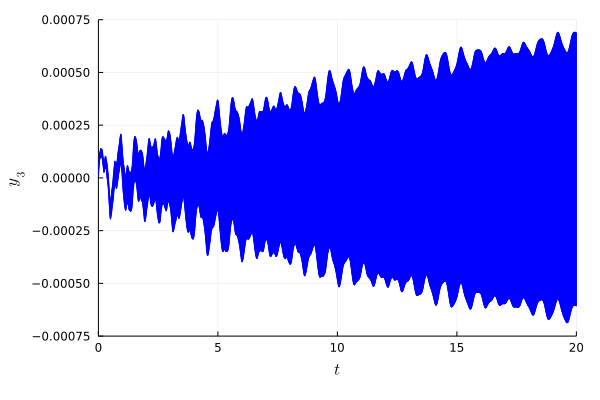

In [6]:
dim(πsol_ISSF01)


using Plots, Plots.PlotMeasures, LaTeXStrings

fig = Plots.plot();
Plots.plot!(fig, πsol_ISSF01[1:10:end], vars=(0, 1), linecolor=:blue, color=:blue, alpha=0.8,
     xlab=L"t",
     ylab=L"y_{3}",
     xtick=[0, 5, 10, 15, 20.], ytick=[-0.00075, -0.0005, -0.00025, 0, 0.00025, 0.0005, 0.00075],
     xlims=(0., 20.), ylims=(-0.00075, 0.00075),
     bottom_margin=6mm, left_margin=2mm, right_margin=4mm, top_margin=3mm);
fig

### ISSC01

In this scenario the inputs are uncertain only in their initial
value and constant over time.

In [7]:
function ISSC01()
    @load ISS_path A B

    A_ext = add_dimension(A, 3)
    A_ext[1:270, 271:273] = B

    U = Hyperrectangle(low=[0.0, 0.8, 0.9], high=[0.1, 1., 1.])
    X0 = BallInf(zeros(size(A, 1)), 0.0001)
    X0 = X0 * U
    return @ivp(x' = A_ext*x, x(0) ∈ X0)
end

ISSC01 (generic function with 1 method)

In [8]:
dirs = CustomDirections([C3_ext, -C3_ext]);
prob_ISSC01 = ISSC01();
sol_ISSC01 = solve(prob_ISSC01, T=20.0, alg=LGG09(δ=0.01, template=dirs, sparse=true, cache=false));

We can flatten the flowpipe to the output $y_3(t)$ as before:

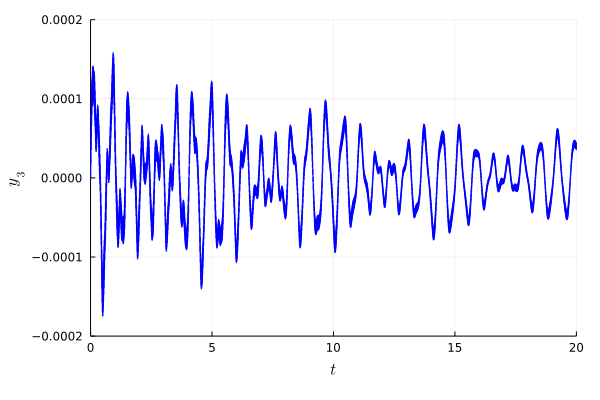

In [9]:
πsol_ISSC01 = flatten(sol_ISSC01);

fig = Plots.plot();
Plots.plot!(fig, πsol_ISSC01, vars=(0, 1), linecolor=:blue, color=:blue, alpha=0.8, lw=1.0,
    xlab=L"t",
    ylab=L"y_{3}",
    xtick=[0, 5, 10, 15, 20.], ytick=[-0.0002, -0.0001, 0.0, 0.0001, 0.0002],
    xlims=(0., 20.), ylims=(-0.0002, 0.0002),
    bottom_margin=6mm, left_margin=2mm, right_margin=4mm, top_margin=3mm)
fig

## References

[^ASG00]: Antoulas, Athanasios C., Danny C. Sorensen, and Serkan Gugercin. A survey of model reduction methods for large-scale systems. 2000.

[^TLT16]: Tran, Hoang-Dung, Luan Viet Nguyen, and Taylor T. Johnson. *Large-scale linear systems from order-reduction (benchmark proposal).* 3rd Applied Verification for Continuous and Hybrid Systems Workshop (ARCH), Vienna, Austria. 2016.